# Introduction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import re
import subprocess
from collections import Counter

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import nltk.corpus
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem import WordNetLemmatizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

try: 
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-emotion-classification-dataset/train-00000-of-00001.parquet
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/workin

In [2]:
file_name = '/kaggle/input/twitter-emotion-classification-dataset/train-00000-of-00001.parquet'

full_data = pd.read_parquet(file_name)

In [3]:
full_data.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


# EDA, Data Cleaning, and Visualizations

#### I'll need to spend some time later this week figuring out a visualization plan for this data, how do I want to communicate information about a set as simple as some text and an emotion?

In [5]:
# Map of labels to emotions -- from dataset overview page: https://www.kaggle.com/datasets/aadyasingh55/twitter-emotion-classification-dataset/data
topic_mapping = {
    0:'sadness',
    1:'joy',
    2:'love',
    3:'anger',
    4:'fear',
    5:'surprise'
}
full_data['emotion'] = full_data['label'].map(topic_mapping)

In [6]:
full_data[['text', 'emotion']].head()

,text,emotion
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


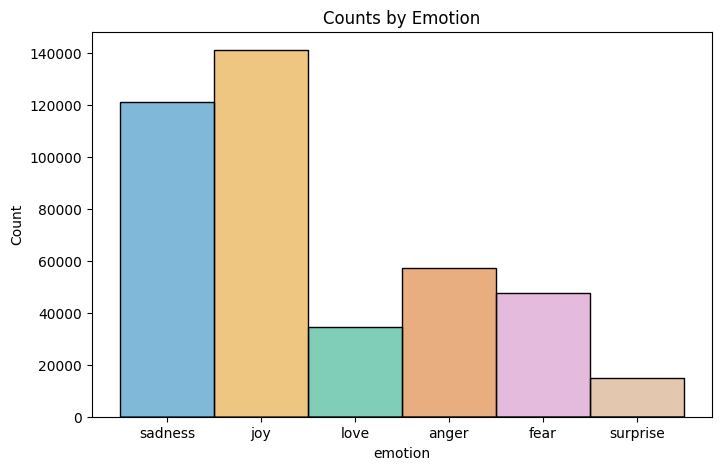

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(
    data = full_data,
    x = 'emotion',
    hue = 'emotion',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Counts by Emotion');

#### We have some very unbalanced categories here, we'll explore some upsampling techniques during training to see how it affects performance

## Stop words and Tokenizing

#### The text in the dataset has already undergone some cleaning, but we'll still do some extra cleaning: removing stop words and tokenizing the text

In [8]:
def clean_text(df, text_col):
    # remove any urls
    df['no_url'] = df[text_col].apply(lambda row: re.sub(r'https?://\S+|www\.\S+', '', row))
    
    # remove any punctuation
    df['no_punct'] = df['no_url'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    
    # get rid of numbers 
    df['no_punct_num'] = df['no_punct'].apply(lambda row: re.sub(r'[0-9]+', '', row))
    
    # remove any common words (this list was derived from the word frequency graphs below)
    common_words = ['feel', 'feeling', 'like', 'im', 'time']
    df['clean_text'] = df['no_punct_num'].apply(lambda x: ' '.join([word for word in x.split() if word not in (common_words)]))

    # Drop the intermediary columns
    df.drop(['no_url', 'no_punct', 'no_punct_num'], axis=1, inplace=True)
    
    return 

In [9]:
clean_text(full_data, 'text')

In [10]:
full_data.head()

,text,label,emotion,clean_text
0,i feel awful about it too because it s my job ...,0,sadness,i awful about it too because it s my job to ge...
1,im alone i feel awful,0,sadness,alone i awful
2,ive probably mentioned this before but i reall...,1,joy,ive probably mentioned this before but i reall...
3,i was feeling a little low few days back,0,sadness,i was a little low few days back
4,i beleive that i am much more sensitive to oth...,2,love,i beleive that i am much more sensitive to oth...


In [11]:
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

def tokenize_lemmatize(text):
    tokens = tokenizer.tokenize(text)
    stop_words = stopwords.words('english')
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return ' '.join(tokens)

In [12]:
full_data['tokens'] = full_data['clean_text'].apply(lambda x: tokenize_lemmatize(x))
full_data[['text', 'clean_text', 'tokens']].head()

,text,clean_text,tokens
0,i feel awful about it too because it s my job ...,i awful about it too because it s my job to ge...,awful job get position succeed happen
1,im alone i feel awful,alone i awful,alone awful
2,ive probably mentioned this before but i reall...,ive probably mentioned this before but i reall...,ive probably mentioned really proud actually k...
3,i was feeling a little low few days back,i was a little low few days back,little low day back
4,i beleive that i am much more sensitive to oth...,i beleive that i am much more sensitive to oth...,beleive much sensitive people feeling tend com...


## Word Frequencies and Other Goodies

#### we'll do some visualizations here eventually

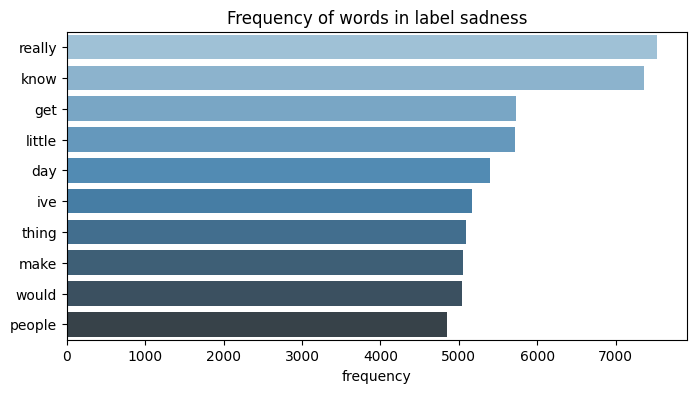

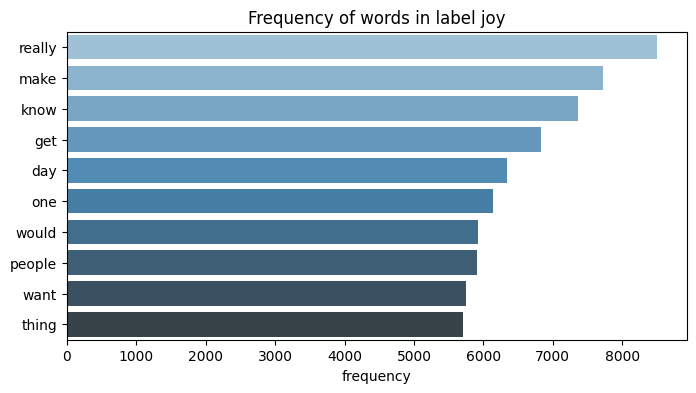

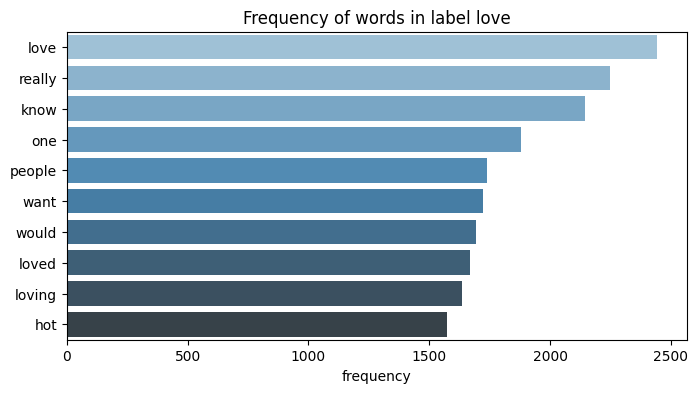

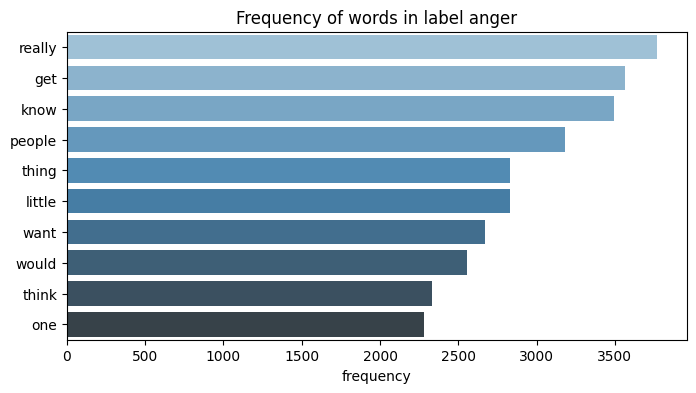

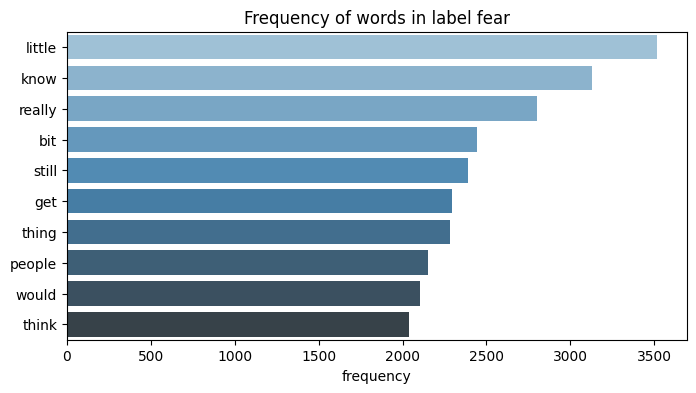

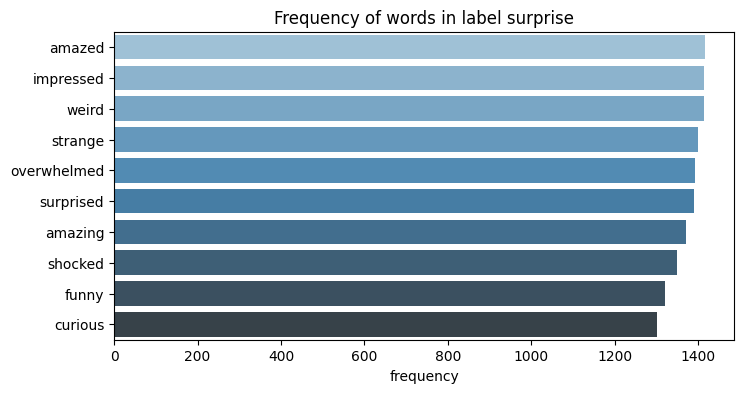

In [13]:
for label in full_data['emotion'].unique():

    text = " ".join(full_data[full_data['emotion'] == label]['tokens']).split()

    most_common = Counter(text).most_common(10)

    word, counts = zip(*most_common)



    plt.figure(figsize=(8,4))

    sns.barplot(x=list(counts), y=list(word), palette="Blues_d")

    plt.title(f"Frequency of words in label {label}")

    plt.xlabel('frequency')

    plt.show()

# Modeling and Predicting

#### The first thing we'll do is split into our Train/Test datasets. We have over 400,000 examples so a 75% train / 25% test split should be MORE than enough data for our needs

In [14]:
X_full = full_data['tokens']
y_full = full_data['label']

X_train, X_test, y_train, y_test = train_test_split(
        X_full,
        y_full,
        train_size = 0.75,
        random_state=4133,
        stratify=y_full
    )

## TD-IDF vs Bag-of-Words vs Word2Vec

## Unsupervised Methods

## Supervised Methods

# Comparisons and Conclusions